# MGL869 - Projet personnel

*MGL869 ETS Montreal - Production engineering*

## Abstract

## Authors
- **William PHAN**

---

## Part 1 : Collecte des données

In [1]:
from Jira import jira_download
from pandas import Index
from numpy import ndarray


### 1.1 - Téléchargement des données Jira

Nous téléchargeons les données si elles ne sont pas déjà présentes dans le dossier de données.

Renvoie le dataframe des données.

Le filtre de requête peut être défini dans le fichier config.ini.

In [2]:
jira_dataframe = jira_download()

Data already downloaded
Filter = 'project=HIVE AND issuetype=Bug AND status in (Resolved, Closed) AND affectedVersion>= 2.0.0'


### 1.2 - Nettoyer les données Jira en utilisant pandas

Auparavant, nous avons téléchargé toutes les données de Jira. Maintenant, nous allons nettoyer les données en utilisant pandas. Nous allons conserver seulement certaines colonnes et combiner certaines colonnes.

In [3]:
keep: [str] = ['Issue key', 'Status', 'Resolution', 'Created', 'Fix Versions Combined', 'Affects Versions Combined']

In [4]:
affects_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Affects Version/s')]
jira_dataframe['Affects Versions Combined'] = jira_dataframe[affects_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)

In [5]:
# Combine the versions into a single column
fix_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Fix Version/s')]

jira_dataframe['Fix Versions Combined'] = jira_dataframe[fix_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)
jira_dataframe = jira_dataframe.loc[:, keep]

In [6]:
# Identify columns whose names contain the string 'Issue key'
issue_key_columns: Index = jira_dataframe.columns[jira_dataframe.columns.str.contains('Issue key')]
# Extract the values from these columns as a NumPy array
issue_key_values: ndarray = jira_dataframe[issue_key_columns].values
# Flatten the array to create a one-dimensional list of all 'Issue key' values
flattened_issue_keys: ndarray = issue_key_values.flatten()
# Convert the list into a set to remove duplicates
ids: set = set(flattened_issue_keys)

---


## Part 2 : Analyse du répo git


In [7]:
from Hive import git_download, commit_analysis, update_commit_dataframe, filter_versions_by_min
from git import Repo, Tag
from pandas import DataFrame
from configparser import ConfigParser
from re import compile
from packaging import version  

### 2.1 - Clonage du répo

In [8]:
repo: Repo = git_download()

Output/hive_data/hiveRepo False
Pulling the repository: https://github.com/apache/hive.git


In [9]:
all_couples = commit_analysis(ids)

20524 couples found.


### 2.2 - Filtrage des données et couples

In [10]:
commit_dataframe: DataFrame = DataFrame(all_couples, columns=["Issue key", "File", "Commit"])

In [11]:
# Languages without whitespaces
config: ConfigParser = ConfigParser()
config.read("config.ini")
languages: [str] = config["GENERAL"]["Languages"].split(",")
languages: [str] = [lang.strip() for lang in languages]
commit_dataframe: DataFrame = commit_dataframe[commit_dataframe['File'].str.endswith(tuple(languages))]

In [12]:
couples = update_commit_dataframe(commit_dataframe, jira_dataframe)
couples
filtered_couples = couples[couples['Version Affected'].str.contains('2.3.9', na=False)]
filtered_couples

,Issue key,File,Version Affected
147,HIVE-27960,ql/src/java/org/apache/hadoop/hive/ql/exec/Reg...,"2.3.9, 4.0.0-beta-1"


### 2.3 - Collecte des versions filtrées

In [13]:
releases_regex: [str] = config["GIT"]["ReleasesRegex"].split(",")
tags: Tag = repo.tags
versions: dict = {tag.name: tag.commit for tag in tags}
releases_regex: [str] = [regex.strip() for regex in releases_regex]
releases_regex = [compile(regex) for regex in releases_regex]

In [14]:
filtered_versions = filter_versions_by_min(versions, releases_regex, "2.0.0")

In [15]:
# from packaging.version import Version

# sorted_versions = dict(
#     sorted(filtered_versions.items(), key=lambda item: Version(item[0]), reverse=True)
# )

# sorted_versions

## Part 3. - Analyse des métriques statiques via Understand

In [16]:
from Understand.commands import und_create_command, und_purge_command
from Understand.metrics import metrics
from Understand.label import label_all_metrics
from os import path
from Understand import merge_static_metrics
from Understand.enrich import enrich_metrics
from Understand.update import merge_all_metrics

### 3.1 - Création du projet Understand

In [17]:
hive_git_directory: str = config["GIT"]["HiveGitDirectory"]
data_directory: str = config["GENERAL"]["DataDirectory"]
understand_project_name : str = config["UNDERSTAND"]["UnderstandProjectName"]

understand_project_path : str = path.join(data_directory, hive_git_directory, understand_project_name)

if not path.exists(understand_project_path):
    und_create_command()

In [18]:
und_purge_command()

Running command : 
     /Applications/Understand.app/Contents/MacOS/und purge -db Output/hive_data/hive.und
Database purged.



### 3.2 - Extraction des métriques


In [19]:
metrics(filtered_versions)

Metrics analysis is skipped as per configuration.


### 3.3 - Labélisation


In [20]:
label_all_metrics(couples)

Labelization process is skipped as per configuration.


In [21]:
enrich_metrics(couples)

Enrichment process is skipped as per configuration.


In [22]:
v = [
    "2.0.0", "2.0.1", "2.1.0", "2.1.1", "2.2.0", "2.3.0", "2.3.1", "2.3.2",
    "2.3.3", "2.3.4", "2.3.5", "2.3.6", "2.3.7", "2.3.8", "2.3.9", "2.3.10",
    "3.0.0", "3.1.0", "3.1.1", "3.1.2", "3.1.3", "4.0.0", "4.0.1"
]
merge_all_metrics(v)

Error processing version 2.0.0: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.0.0_labeled_metrics.csv'
Error processing version 2.0.1: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.0.1_labeled_metrics.csv'
Error processing version 2.1.0: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.1.0_labeled_metrics.csv'
Error processing version 2.1.1: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.1.1_labeled_metrics.csv'
Error processing version 2.2.0: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.2.0_labeled_metrics.csv'
Error processing version 2.3.0: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.3.0_labeled_metrics.csv'
Error processing version 2.3.1: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.3.1_labeled_metrics.csv'
Error processing version 2.3.2: [Errno 2] No such file or directory: 'Output/static_metrics_output/2.3.2_labeled_metri

In [23]:
merge_static_metrics()

Merging has already been done. Skipping...


# Part 4. - Entraînement du modèle

In [24]:
import os
from configparser import ConfigParser
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_lr, evaluate_model, train_model, load_and_prepare_data, load_config
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [25]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

['config.ini']

### 4.1 - Evaluation of RF and LR models for all versions

Dans cette partie, il est important de souligner que le modèle construit se base sur les données du csv augmentée contenant le résultat de TOUTES les versions taguées depuis la 2.0.0. Le fichier se trouve dans le dossier src/Output/temp_static_metrics_output

In [26]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["UNDERSTAND"]["FullStaticMetricsOutputDirectory"]
file_name = config["UNDERSTAND"]["MergedStaticMetricsFileName"]
file_path = os.path.join(data_directory, output_dir, file_name)

In [27]:
# Retrieve configuration settings
config_section = "VERSION_ALL"
param = load_config(config_section)

model_instance_lr = LogisticRegression(max_iter=5000, class_weight='balanced')
print("Running pipeline with the model: Logistic Regression")
X_train_lr, X_test_lr, y_train_lr, y_test_lr = load_and_prepare_data(file_path,param)
trained_model_lr = train_model(model_instance_lr, X_train_lr, y_train_lr)
metrics_lr = evaluate_model(trained_model_lr, X_test_lr, y_test_lr) 

# Random Forest
model_instance_rf = RandomForestClassifier(class_weight='balanced')
X_train_rf, X_test_rf, y_train_rf, y_test_rf = load_and_prepare_data(file_path,param)
print("Running pipeline with the model: Random Forest")
trained_model_rf = train_model(model_instance_rf, X_train_rf, y_train_rf)
metrics_rf = evaluate_model(trained_model_rf, X_test_rf, y_test_rf)


Running pipeline with the model: Logistic Regression
Scaler fit/transform time: 0.05 seconds
Training time: 1.56 seconds
Prediction time: 0.01 seconds
Scaler fit/transform time: 0.05 seconds
Running pipeline with the model: Random Forest
Training time: 31.55 seconds
Prediction time: 0.88 seconds


In [28]:
metrics_lr

{'AUC': np.float64(0.6388558821428626),
 'Precision': np.float64(0.6357673121489453),
 'Recall': np.float64(0.4610476543139545),
 'FPR': [0.0,
  0.0,
  0.0,
  2.8595939376608523e-05,
  2.8595939376608523e-05,
  2.8595939376608523e-05,
  5.7191878753217045e-05,
  5.7191878753217045e-05,
  0.00011438375750643409,
  0.00011438375750643409,
  0.00014297969688304262,
  0.00014297969688304262,
  0.00014297969688304262,
  0.00014297969688304262,
  0.00017157563625965112,
  0.00017157563625965112,
  0.00017157563625965112,
  0.00017157563625965112,
  0.00020017157563625965,
  0.00020017157563625965,
  0.00022876751501286818,
  0.00022876751501286818,
  0.0002573634543894767,
  0.0002573634543894767,
  0.0003717472118959108,
  0.0003717472118959108,
  0.0003717472118959108,
  0.0003717472118959108,
  0.0005147269087789534,
  0.0005147269087789534,
  0.0005433228481555619,
  0.0005433228481555619,
  0.0005719187875321705,
  0.0005719187875321705,
  0.000600514726908779,
  0.000600514726908779,
 

In [29]:
metrics_rf

{'AUC': np.float64(0.9651720799566477),
 'Precision': np.float64(0.9581201950402345),
 'Recall': np.float64(0.9123251773150653),
 'FPR': [0.0,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030311695739205034,
  0.0030883614526737205,
  0.0030883614526737205,
  0.0030883614526737205,
  0.003

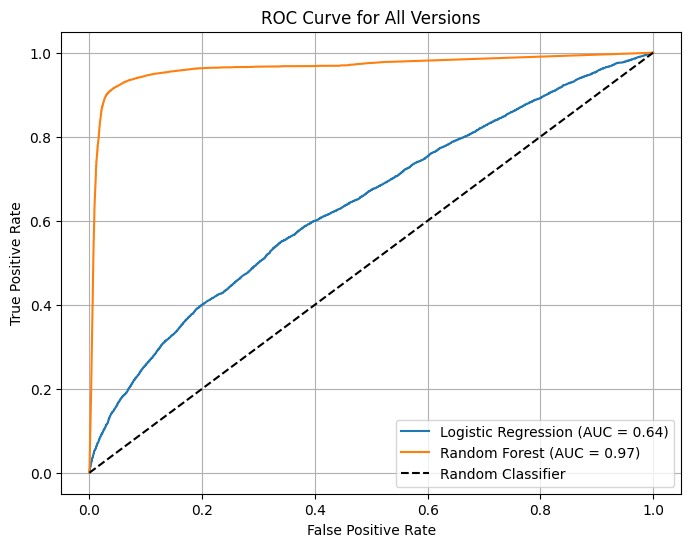

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(metrics_lr["FPR"], metrics_lr["TPR"],
         label=f"Logistic Regression (AUC = {metrics_lr['AUC']:.2f})")
plt.plot(metrics_rf["FPR"], metrics_rf["TPR"],
         label=f"Random Forest (AUC = {metrics_rf['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Versions')
plt.legend()
plt.grid()
plt.show()


#### Analyse des métriques :
AUC (aire sous la courbe ROC):
L’AUC de Random Forest (0.96) est largement supérieure à celle de Logistic Regression (0.64). Cela montre que Random Forest est bien meilleur pour séparer les classes (positifs vs négatifs).

Précision :
Random Forest a une précision de 96 % contre 63 % pour Logistic Regression. Cela signifie que Random Forest fait beaucoup moins d’erreurs quand il prédit une classe positive.

Rappel (Recall) :
Avec un rappel de 91 %, Random Forest détecte presque tous les vrais positifs, alors que Logistic Regression n’en détecte que 46 %.

#### Conclusion :
Le modèle Random Forest est clairement le plus performant. Voici pourquoi :

Il a un AUC proche de 1, ce qui montre qu'il distingue très bien les classes positives et négatives.
Il est très précis (96 %) dans ses prédictions.
Il détecte la grande majorité des positifs réels grâce à son rappel élevé (91 %).

### 4.2 Étude de l'importance des métriques appliqué au modèle de régression linéaire (LR)

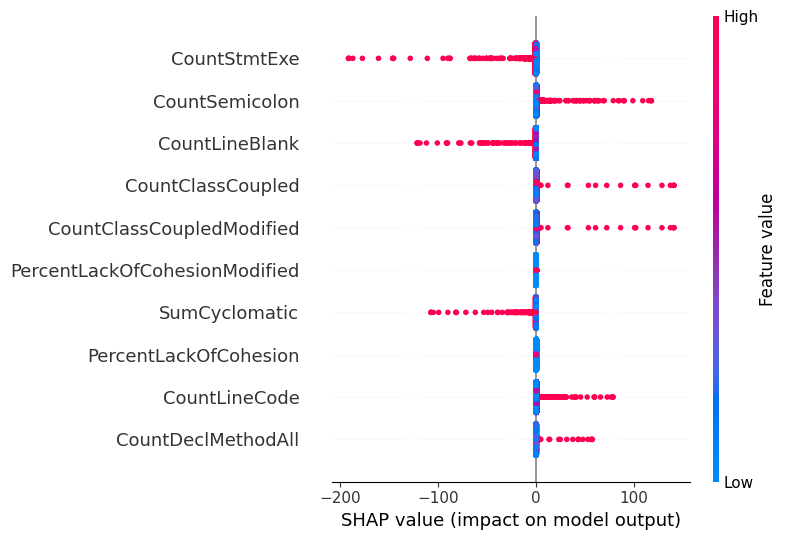

In [31]:
plot_shap_summary(trained_model=trained_model_lr, X_train=X_train_lr, X_test=X_test_lr, top_n=10)

#### Analyse : CountSemicolon 

Rouge à droite (valeurs élevées) : Les valeurs élevées de CountSemicolon (points rouges) tendent à être à droite (SHAP positif). Cela indique qu'un grand nombre de points-virgules dans un fichier augmente la probabilité qu'il contienne un bogue.
Bleu (valeurs faibles) : Les faibles valeurs de CountSemicolon (points bleus) sont centrées autour de zéro. Cela signifie que lorsque CountSemicolon est faible, cette variable a peu d'influence sur la prédiction.

#### Analyse : CountStmtExe
Rouge à gauche (SHAP négatif) :

Les points rouges indiquent des valeurs élevées de CountStmtExe.
Ces points rouges sont majoritairement situés à gauche (valeurs SHAP négatives). Cela signifie que plus la valeur de CountStmtExe est élevée, plus elle diminue la probabilité qu'un fichier contienne un bug.
Impact sur les prédictions :

Grand nombre de points rouges à gauche :
Cela montre que beaucoup de fichiers avec des valeurs élevées de CountStmtExe (nombre d'instructions exécutables) réduisent la probabilité prédite d’un bug.
Cela peut indiquer que des fichiers contenant un grand nombre d’instructions exécutables (potentiellement bien organisées ou bien testées) sont moins susceptibles de contenir des bugs.

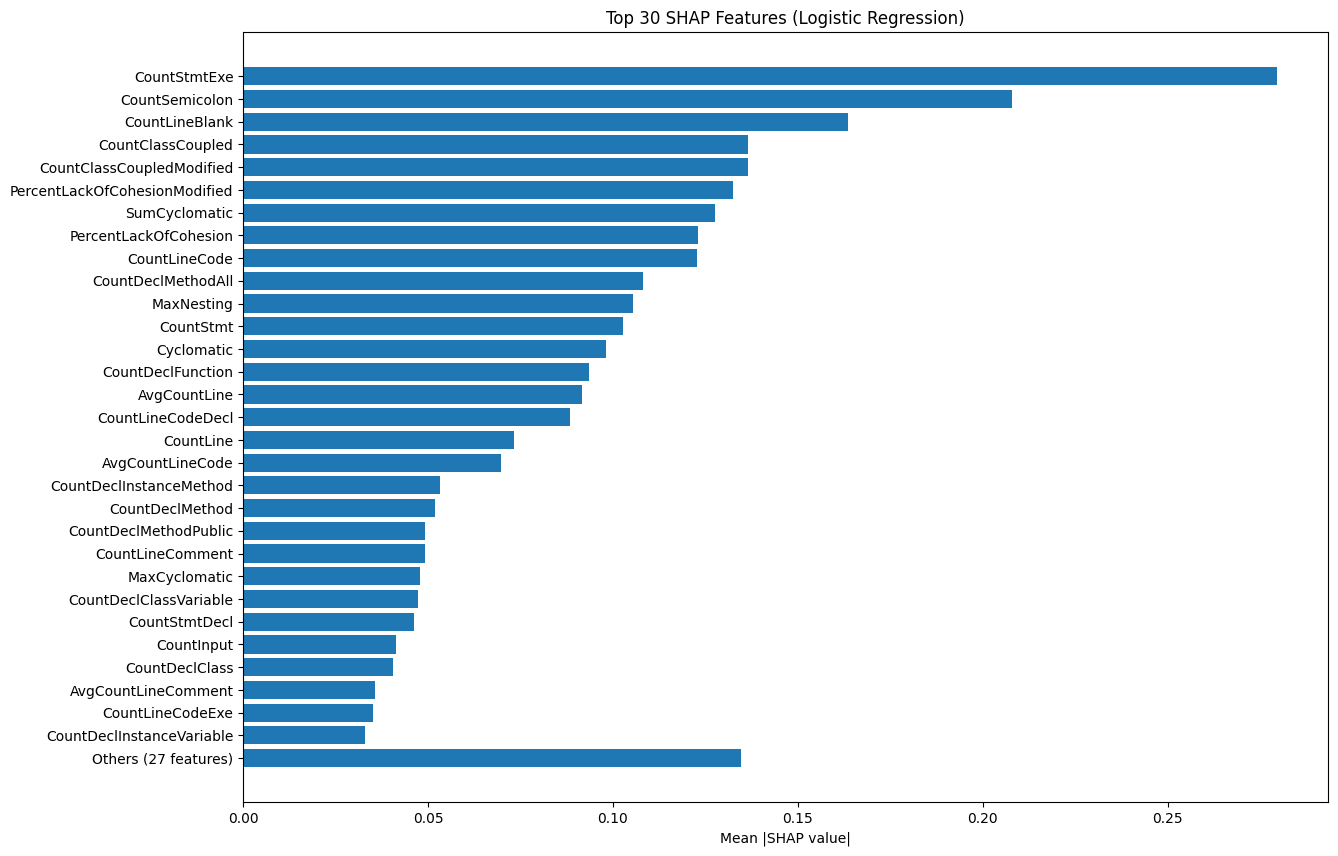

In [42]:
plot_shap_lr(trained_model=trained_model_lr, X_train=X_train_lr, X_test=X_test_lr, top_n=30)


Cette vue résume uniquement l’importance globale (moyenne) absolue, sans afficher les relations locales ni les distributions.

### 4.3 Étude de l'importance des métriques appliqué au modèle de forêt aléatoire (RF)

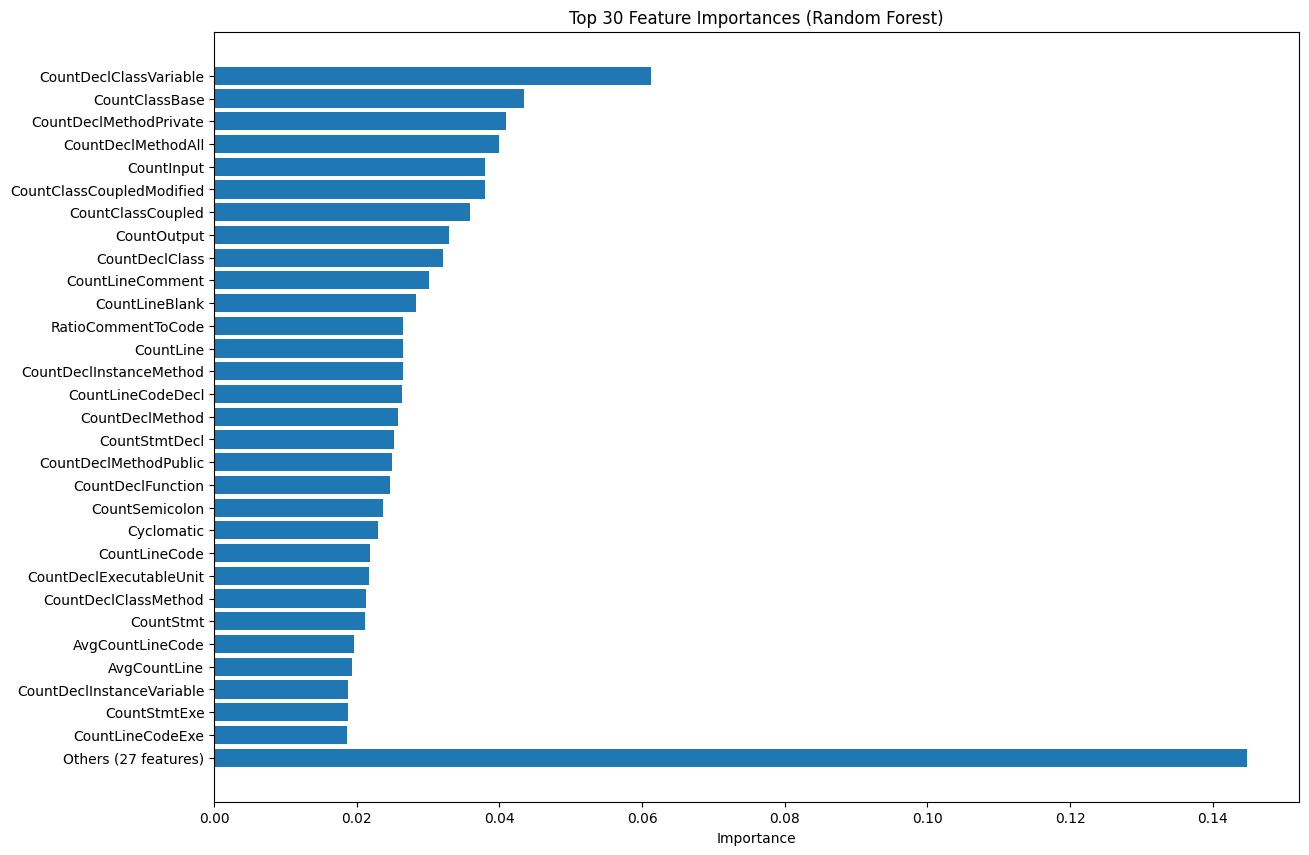

In [43]:
plot_feature_importance_rf(trained_model_rf=trained_model_rf, feature_columns=X_train_rf.columns, top_n=30)

### 4.4 Analyse des résultats et suggestions d'actions pour éviter les bogues

À partir des graphiques montrant les **importances des variables** et les **valeurs SHAP** dans Random Forest uniquement (le meilldeur modèle), nous pouvons identifier les métriques ayant le plus d'impact sur la probabilité de présence d'un bogue. Ces analyses permettent de proposer des actions concrètes pour améliorer la qualité du code et éviter des bogues.

#### 4.4.1 Actions proposées

**Réduire le nombre de déclarations de variables dans les classes (`CountDeclClassVariable`)**  
La métrique `CountDeclClassVariable` est la plus influente. Un grand nombre de variables déclarées dans une classe peut rendre le code complexe, difficile à maintenir, et sujet à des erreurs. Pour adresser ce problème, il est recommandé d'encourager la modularisation des classes en utilisant des sous-classes ou des objets pour encapsuler les variables liées. De plus, des revues de code automatiques pourraient limiter le nombre de variables par classe. Une classe plus concise facilite la lisibilité et diminue les risques d’introduction de bogues liés à des dépendances complexes.

**Optimiser la gestion des classes de base (`CountClassBase`)**  
Le nombre de classes de base est fortement corrélé à la probabilité de bogues, ce qui peut indiquer des hiérarchies de classes complexes ou mal conçues. Pour y remédier, il est conseillé de simplifier les hiérarchies de classes en limitant la profondeur d’héritage et en appliquant des principes de conception comme *Composition over Inheritance*. Des hiérarchies simplifiées favorisent une meilleure lisibilité et limitent les erreurs dues à des relations mal comprises entre classes.

**Réduire la complexité des entrées (`CountInput`)**  
Un nombre élevé d’entrées peut indiquer une complexité dans la gestion des données ou une forte dépendance à des sources externes. Il est important de standardiser les formats d’entrée, limiter les dépendances aux données externes non fiables et ajouter des validations robustes pour éviter les erreurs dues à des données inattendues. Une gestion claire et standardisée des entrées diminue les risques d’erreurs liées à des données mal formées ou non prévues.

**Contrôler le nombre total de méthodes déclarées (`CountDeclMethodAll`)**  
Un grand nombre de méthodes déclarées est corrélé à une complexité accrue, augmentant les risques de bogues. Les classes devraient être refactorisées pour regrouper des fonctionnalités similaires et réduire le nombre de méthodes. Il est également recommandé de limiter le nombre de méthodes publiques pour réduire l’exposition à des erreurs externes. Cependant, il est crucial de veiller à ne pas appauvrir la subdivision du code, ce qui pourrait avoir un effet inverse.

**Limiter les modifications de couplage des classes (`CountClassCoupledModified`)**  
Les modifications fréquentes des relations entre classes couplées augmentent la probabilité de bogues. Pour minimiser ces risques, il est essentiel de favoriser la stabilité des interfaces et de réduire les modifications fréquentes des classes couplées. L’utilisation de tests automatisés peut également valider les modifications dans les dépendances, réduisant ainsi le risque d’introduire des bogues dans les interactions critiques entre classes.


#### 4.4.2 ... Vers une analyse plus fine
Bien que ces analyses offrent des perspectives globales basées sur toutes les versions combinées, elles ne tiennent pas compte de l'évolution des métriques au fil des versions. Il serait pertinent d'explorer comment ces métriques varient entre les versions pour mieux comprendre l'impact des changements dans le temps. Cela permettra d'identifier des tendances ou des patterns susceptibles de causer des bogues dans les futures versions.


## Part 5. - Limitations du modèle


In [34]:
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_lr, evaluate_model, train_model, load_and_prepare_data, load_config, train_and_save_models, plot_metrics_evolution, filter_data_by_version
import os, json
from configparser import ConfigParser
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [35]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

['config.ini']

In [36]:
train_and_save_models()

Model training has already been done. Skipping...


### 5.1 - Analyse des performances des modèles par version

In [37]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["OUTPUT"]["StaticModelsDirectory"]
file_name = config["MODEL"]["StaticPerformanceMetricsFile"]
file_path = os.path.join(data_directory, output_dir, file_name)

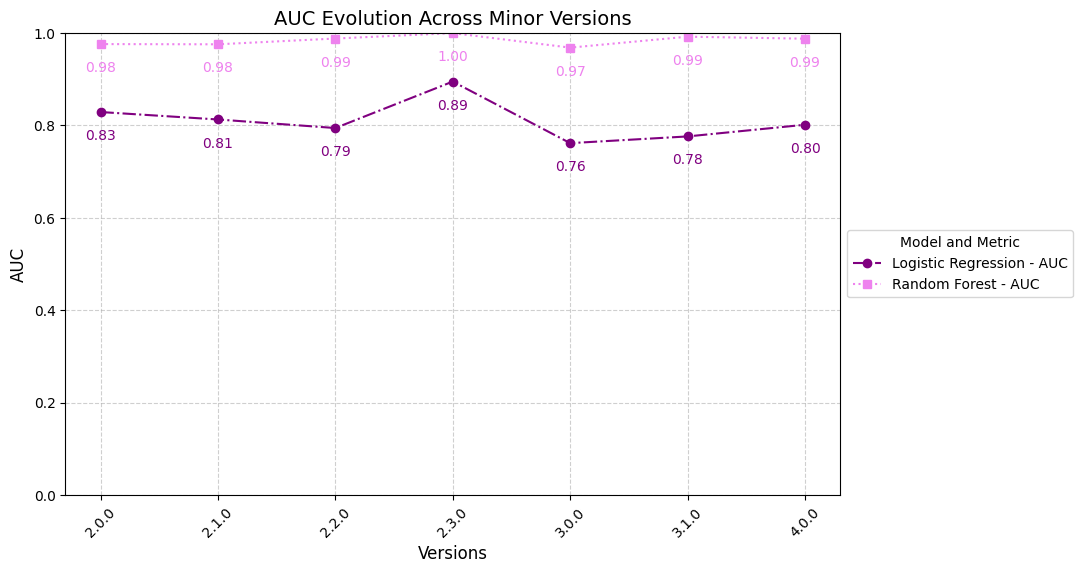

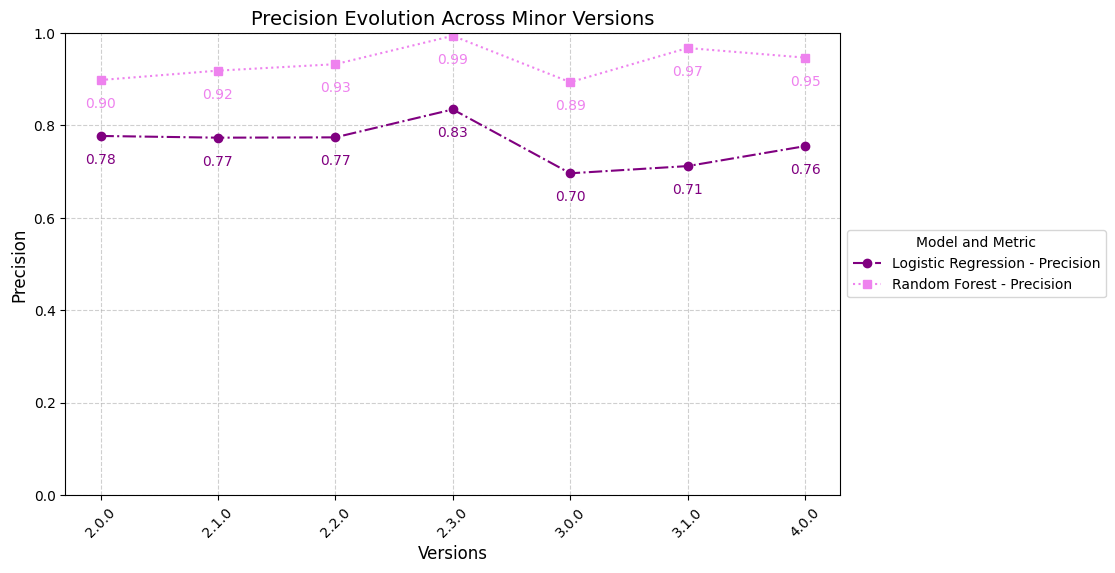

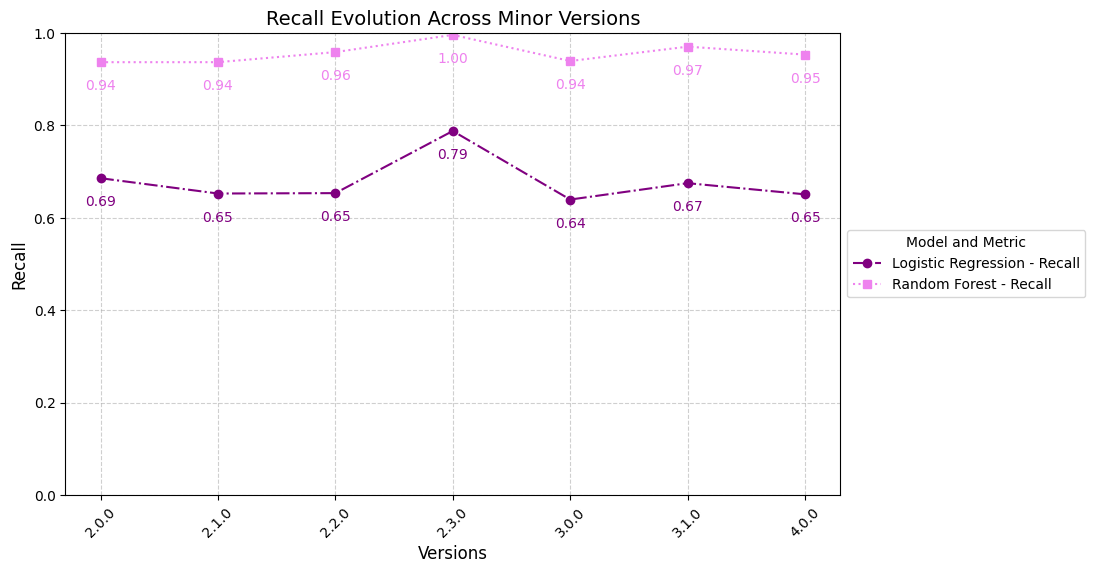

In [38]:
with open(file_path, "r") as f:
    results = json.load(f)

filtered_results = {version: metrics for version, metrics in results.items()}

plot_metrics_evolution(filtered_results)



### 5.2 - Évolution des métriques : AUC, précision et rappel

#### 5.2.1 Comparaison entre les modèles
- **Random Forest** surpasse nettement **Logistic Regression** sur toutes les métriques :
  - AUC, précision et rappel.
- Random Forest est un modèle non linéaire, mieux adapté aux relations complexes dans les données, contrairement à Logistic Regression, qui est linéaire.
- La stabilité des performances de Random Forest est un avantage important, là où Logistic Regression montre des variations importantes.

#### 5.2.2 Comparaison entre Random Forest et Logistic Regression

| **Critère**               | **Random Forest**                          | **Logistic Regression**               |
|---------------------------|--------------------------------------------|---------------------------------------|
| **Relations non linéaires** | Excellente gestion                        | Faible sans transformation            |
| **Robustesse au bruit**     | Très robuste                              | Moins robuste                         |
| **Interactions**            | Capturées automatiquement                 | Nécessitent un ajout manuel           |
| **Classes déséquilibrées**  | Bien gérées                               | Gérées, mais performances variables   |
| **Surapprentissage**        | Limité grâce au bagging                   | Faible risque                         |
| **Interprétabilité**        | Moyenne (via outils externes)             | Très bonne                            |


#### 5.2.3 Conclusion
Les résultats confirment que Random Forest est plus performant et plus stable que Logistic Regression pour la détection des bugs dans les versions de Hive. Cependant, des investigations complémentaires sur les faiblesses de Logistic Regression pourraient améliorer son utilité, en particulier pour des scénarios avec des contraintes de complexité ou de ressources.



### 5.3 - Analyse des métriques entre les versions 2.0 et 3.0 (Pour Random Forest)

In [39]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["UNDERSTAND"]["FullStaticMetricsOutputDirectory"]
file_name = config["UNDERSTAND"]["MergedStaticMetricsFileName"]
file_path = os.path.join(data_directory, output_dir, file_name)

#### 5.3.1 - Comparaison des métriques pour les deux versions majeurs

Scaler fit/transform time: 0.00 seconds
Étude sur la version 2.0
Training time: 1.99 seconds


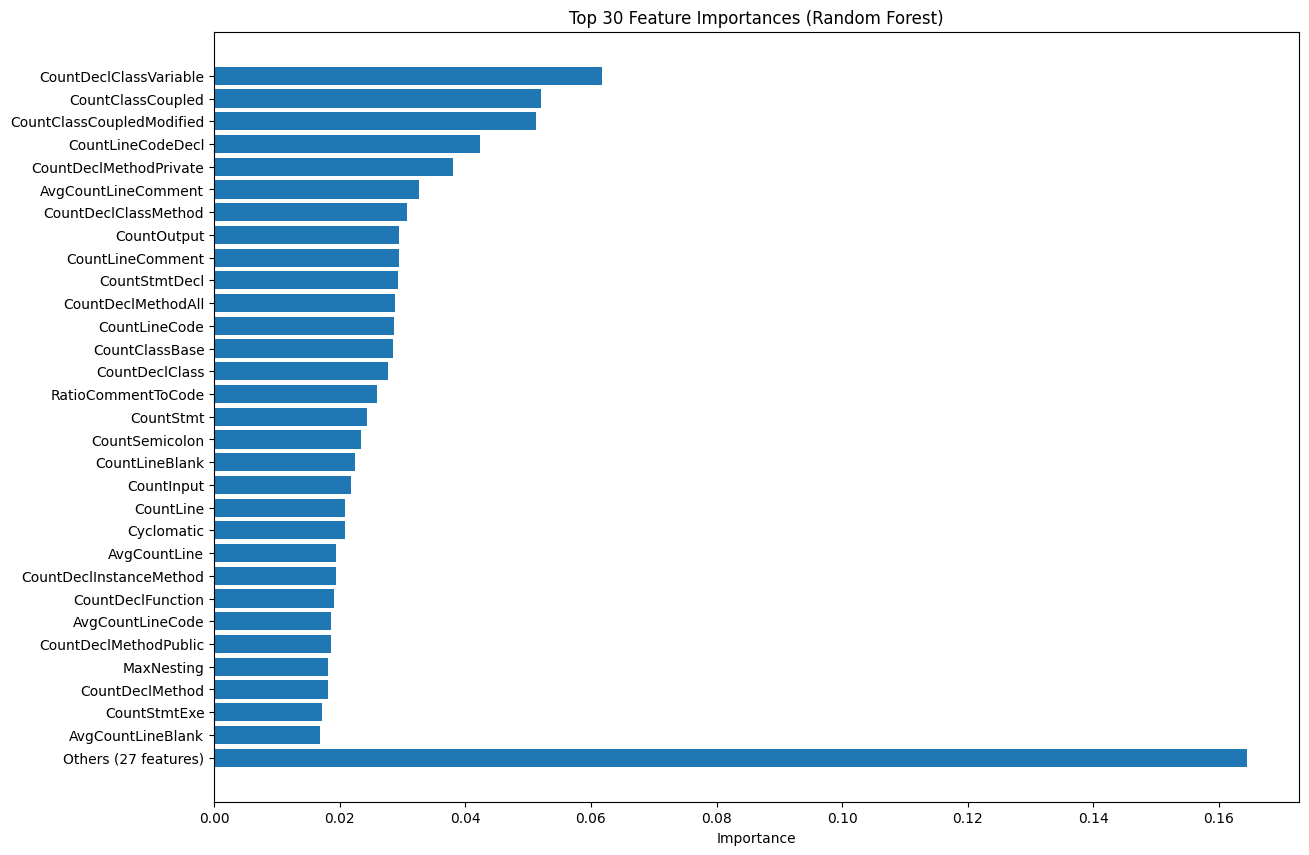

Scaler fit/transform time: 0.00 seconds
Étude sur la version 3.0
Training time: 0.87 seconds


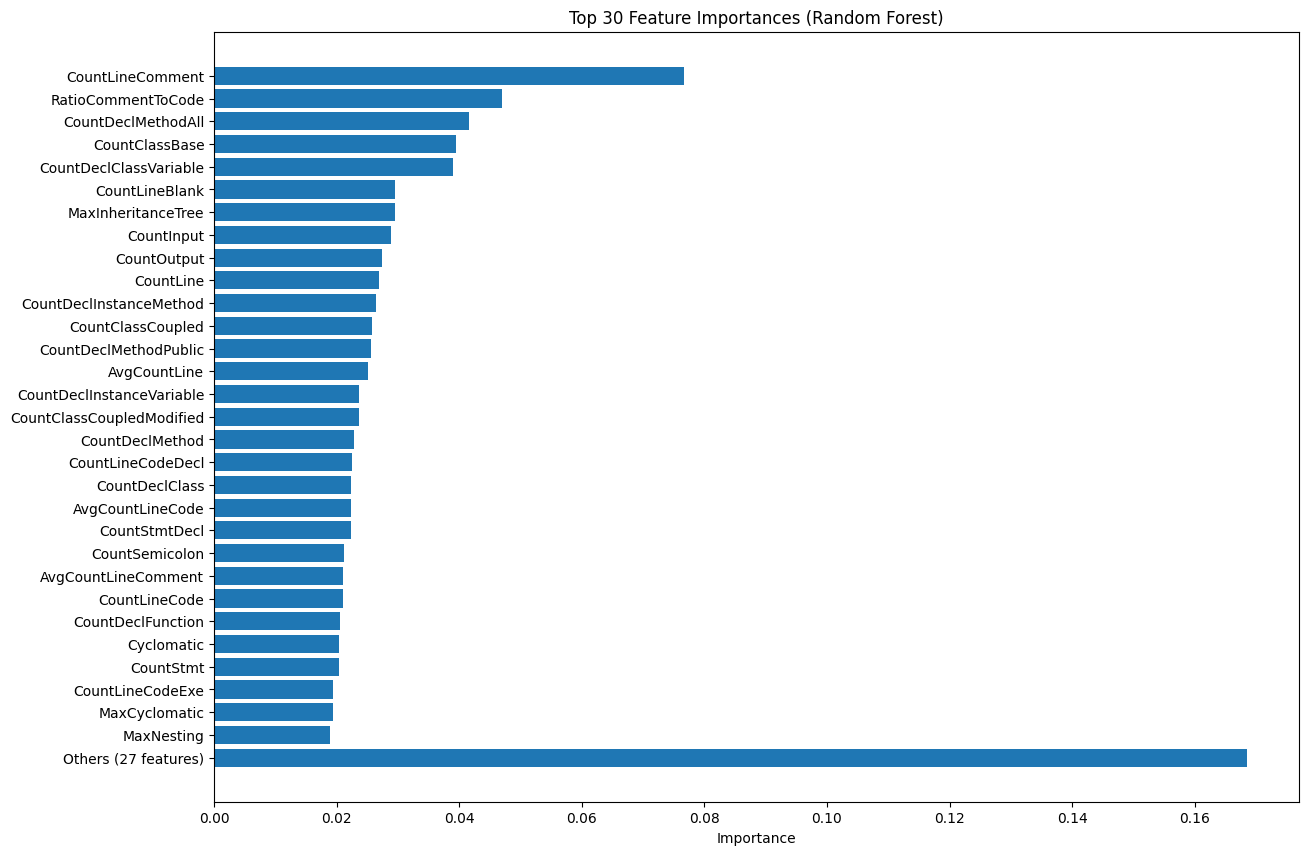

In [40]:
file_path = os.path.join(data_directory, output_dir, file_name)
param = load_config("VERSION")

df = pd.read_csv(file_path, sep=",")
df['Version'] = df['Version'].astype(str)  

df_2_0 = filter_data_by_version(df, "2.0")
df_2_0 = df_2_0.drop(columns=["Version"])
X_train_2_0, X_test_2_0, y_train_2_0, y_test_2_0 = load_and_prepare_data(df_2_0, param)
print("Étude sur la version 2.0")
model_instance_rf_2_0 = RandomForestClassifier(class_weight='balanced')
trained_model_rf_2_0 = train_model(model_instance_rf_2_0, X_train_2_0, y_train_2_0)
plot_feature_importance_rf(trained_model_rf=trained_model_rf_2_0, feature_columns=X_train_2_0.columns, top_n=30)

df_3_0 = filter_data_by_version(df, "3.0")
df_3_0 = df_3_0.drop(columns=["Version"])
X_train_3_0, X_test_3_0, y_train_3_0, y_test_3_0 = load_and_prepare_data(df_3_0, param)
print("Étude sur la version 3.0")
model_instance_rf_3_0 = RandomForestClassifier(class_weight='balanced')
trained_model_rf_3_0 = train_model(model_instance_rf_3_0, X_train_3_0, y_train_3_0)
plot_feature_importance_rf(trained_model_rf=trained_model_rf_3_0, feature_columns=X_train_3_0.columns, top_n=30)


Les résultats obtenus montrent des différences significatives dans l'importance des variables entre les versions 2.0 et 3.0, tout en conservant des performances globales similaires pour les modèles. Dans la version 2.0, les variables les plus influentes sont principalement liées aux déclarations de classes et au couplage, comme CountDeclClassVariable, CountClassCoupledModified, et CountClassCoupled. Cela indique que, pour cette version, la structure du code et la manière dont les classes interagissent sont des facteurs déterminants pour prédire les bugs. En revanche, dans la version 3.0, les variables liées aux commentaires, telles que CountLineComment et RatioCommentToCode, dominent. Ces changements reflètent une évolution dans la base de code où la documentation et la qualité des commentaires prennent davantage d'importance dans la prédiction des erreurs.

#### 5.3.2 Distribution des métriques

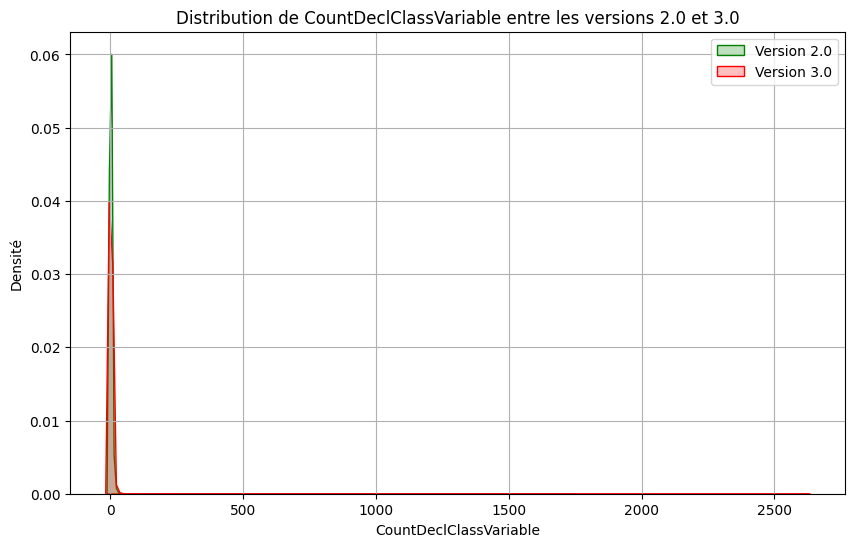

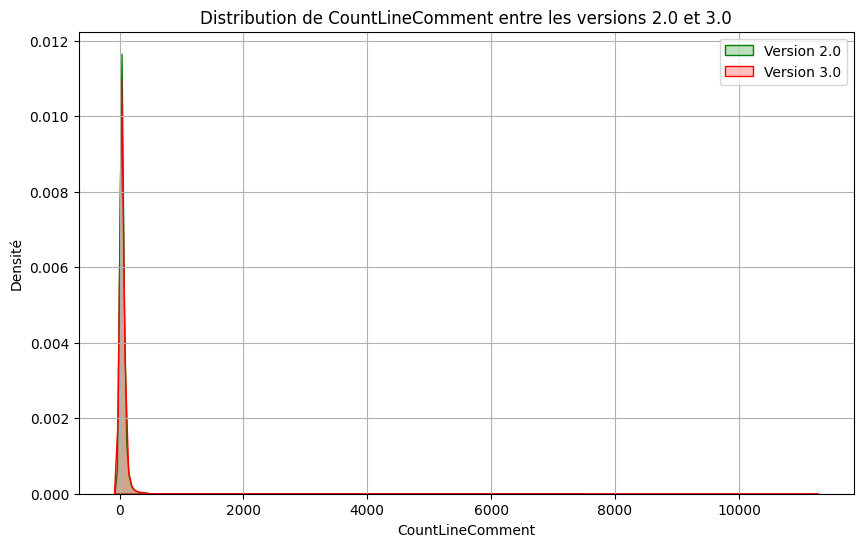

In [ ]:
def plot_variable_distributions(df_2_0, df_3_0, variable):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df_2_0[variable], label="Version 2.0", color="green", fill=True)
    sns.kdeplot(df_3_0[variable], label="Version 3.0", color="red", fill=True)
    plt.title(f"Distribution de {variable} entre les versions 2.0 et 3.0")
    plt.xlabel(variable)
    plt.ylabel("Densité")
    plt.legend()
    plt.grid()
    plt.show()

# Key variables
plot_variable_distributions(df_2_0, df_3_0, "CountDeclClassVariable")
plot_variable_distributions(df_2_0, df_3_0, "CountLineComment")


La distribution des variables entre les deux versions montre des similitudes intéressantes. Les pics autour de 0 indiquent que la majorité des fichiers ont des valeurs faibles pour des métriques comme CountDeclClassVariable et CountLineComment. Cependant, la hauteur des pics varie : pour CountDeclClassVariable, le pic est plus élevé dans la version 2.0 (0.06) que dans la version 3.0 (0.04), ce qui suggère une concentration plus importante de fichiers avec peu de déclarations de variables dans la version 2.0. En revanche, pour CountLineComment, la hauteur des pics est similaire entre les deux versions, ce qui reflète une distribution globalement stable des commentaires dans la base de code, bien que leur importance dans la prédiction des bugs ait augmenté dans la version 3.0.

#### 5.4.3 - Conclusion

Malgré ces différences, les performances des modèles restent stables entre les versions, avec des AUC de 0.98 pour 2.0 et 0.97 pour 3.0, une précision de 0.9 dans les deux cas, et un rappel de 0.94. Cela montre que le modèle s'adapte bien aux données de chaque version tout en capturant des caractéristiques différentes. Cependant, ces résultats soulignent la nécessité pour Hive de mettre à jour ses modèles à chaque version majeure. L'évolution des variables importantes entre les versions indique que les caractéristiques prédictives des bugs changent avec le temps, probablement en raison des nouvelles pratiques de développement et de l'évolution de la base de code. Utiliser un modèle basé sur une version précédente, comme celui de 2.0 pour prédire les bugs dans 3.0, risquerait de négliger des facteurs clés, comme l'importance croissante des commentaires dans la version 3.0.

**Ainsi, il est fortement recommandé de mettre à jour le modèle pour chaque version majeure afin de garantir une prise en compte optimale des changements dans les pratiques de développement et les caractéristiques du code.**